# Objectives
Within this example, we perform a Doppler residual analysis for the GRAIL spacecraft. Unlike the estimation script (see **`grail_odf_estimation.ipynb`**), which fits an orbit to the data, this script assesses the accuracy of the physical observation models by comparing real ODF Doppler measurements against synthetic observables simulated using the reference SPICE trajectory. The script follows this methodology:

1) **Data Loading**: Loading raw ODF files containing Doppler measurements and filtering them for the specific time intervals of interest.

2) **Reference Trajectory**: Utilizing the high-precision reference SPICE trajectory for GRAIL (instead of propagating a dynamic orbit) to serve as the "ground truth" geometry for simulation.

3) **Sensitivity Analysis**: Running four parallel setups to evaluate the impact of specific model components on the residuals:

- **Default**: Full fidelity model.

- **Antenna Offset**: Neglecting the offset between the Center of Mass (CoM) and the antenna phase center.

- **Troposphere**: Neglecting corrections for the Earth's troposphere.

- **Ionosphere**: Neglecting corrections for the Earth's ionosphere.

4) **Residual Computation**: Calculating the difference between the simulated Doppler observables (derived from the SPICE trajectory and physical models) and the actual ODF observations.

5) **Analysis**: Computing RMS and mean residuals to quantify the error introduced by ignoring specific physical corrections.

## Important Remarks
- Before running this script, please make sure you are using **Tudatpy v1.0 or above**.
- **Data Download**: Running the example automatically triggers the download of all required kernels and data files if they are not found locally (trajectory/orientation kernels, ODF files, atmospheric corrections). This initial download may take significant time (~1h).
- **Parallel Execution**: The script utilizes the multiprocessing module to run the four different model setups in parallel, producing output files (of type: *grail_residuals_output_x.dat*) and comparative plots for validation.

In [2]:
# Load required standard modules
import multiprocessing as mp
import numpy as np
from matplotlib import pyplot as plt
import os
# Load required tudatpy modules
from datetime import datetime
from tudatpy.data import grail_antenna_file_reader
from tudatpy.interface import spice
from tudatpy.math import interpolators
from tudatpy.astro import time_representation
from tudatpy import util
from tudatpy.dynamics import environment_setup
from tudatpy.dynamics.environment_setup import radiation_pressure
from tudatpy import estimation
from tudatpy.estimation import estimation_analysis
from tudatpy.estimation import observable_models_setup
from tudatpy.estimation import observations, observations_setup
# Import GRAIL examples functions
from grail_examples_functions import get_grail_files, get_grail_panel_geometry

# The Main Function

We pack the main residual analysis functionality into the `perform_residuals_analysis` function. 

This function evaluates the quality of the orbit determination results obtained from the previous fitting step. It assesses how well the GRAIL dynamical model, updated with the estimated parameters, matches the reference spice trajectory. This is done by propagating the orbit using the best-fit parameters and computing the residuals (the difference between the "observed" spice ephemeris and the computed model positions) to generate statistical metrics and visual plots.

The "inputs" variable used as input argument is a list with eleven entries:

1) the index of the current run (used for parallel process identification)

2) the date for the day-long arc under consideration

3) the index of the setup to consider (referencing the specific dynamical model and the estimated parameters from the fit)

4) the clock file to be loaded

5) the list of orientation kernels to be loaded

6) the GRAIL manoeuvres file to be loaded

7) the list of GRAIL trajectory files to be loaded (reference data)

8) the GRAIL reference frames file to be loaded

9) the lunar orientation kernel to be loaded

10) the lunar reference frame kernel to be loaded

11) the output files directory (where the fit results are read from and analysis plots/reports are saved)

In [6]:
def perform_residuals_analysis(inputs):

    # Unpack various input arguments
    input_index = inputs[0]

    # Convert start and end datetime objects to Tudat Time variables.
    start_date = time_representation.DateTime.from_python_datetime(inputs[1]).to_epoch()
    end_date = time_representation.DateTime.from_python_datetime(inputs[2]).to_epoch()

    # Retrieve lists of relevant kernels and input files to load (ODF files, clock and orientation kernels for GRAIL,
    # tropospheric and ionospheric corrections, antennas switch files, GRAIL trajectory files, GRAIL reference frames file,
    # lunar orientation kernels, and lunar reference frame kernel)
    odf_files = inputs[3]
    clock_file = inputs[4]
    grail_orientation_files = inputs[5]
    tro_files = inputs[6]
    ion_files = inputs[7]
    antennas_switch_files = inputs[8]
    trajectory_files = inputs[9]
    grail_ref_frames_file = inputs[10]
    lunar_orientation_file = inputs[11]
    lunar_ref_frame_file = inputs[12]

    # Retrieve output folder
    output_folder = inputs[13]

    # Redirect the outputs of this run to a file names grail_residuals_output_x.dat, with x the run index
    with util.redirect_std(
        output_folder + "grail_residuals_output_" + str(input_index) + ".dat",
        True,
        True,
    ):

        print("input_index", input_index)

        filename_suffix = str(input_index)

        ### ------------------------------------------------------------------------------------------
        ### LOAD ALL REQUESTED KERNELS AND FILES
        ### ------------------------------------------------------------------------------------------

        # Load standard spice kernels
        spice.load_standard_kernels()

        # Load specific Moon kernels
        spice.load_kernel(lunar_ref_frame_file)
        spice.load_kernel(lunar_orientation_file)

        # Load GRAIL frame definition file (useful for spacecraft-fixed frames definition)
        spice.load_kernel(grail_ref_frames_file)

        # Load GRAIL orientation kernels (over the entire relevant time period).
        for orientation_file in grail_orientation_files:
            spice.load_kernel(orientation_file)

        # Load GRAIL clock file
        spice.load_kernel(clock_file)

        # Load GRAIL trajectory kernel
        for trajectory_file in trajectory_files:
            spice.load_kernel(trajectory_file)

        ### ------------------------------------------------------------------------------------------
        ### LOAD ODF OBSERVATIONS AND PERFORM PRE-PROCESSING STEPS
        ### ------------------------------------------------------------------------------------------

        # Load ODF files
        multi_odf_file_contents = (
            observations_setup.observations_wrapper.process_odf_data_multiple_files(
                odf_files, "GRAIL-A", True
            )
        )

        # Create observation collection from ODF files, only retaining Doppler observations. An observation collection contains
        # multiple "observation sets". Within a given observation set, the observables are of the same type (here Doppler) and
        # defined from the same link ends. However, within the "global" observation collection, multiple observation sets can
        # typically be found for a given observable type and link ends, but they will cover different observation time intervals.
        # When loading ODF data, a separate observation set is created for each ODF file (which means the time intervals of each
        # set match those of the corresponding ODF file).
        original_odf_observations = observations_setup.observations_wrapper.create_odf_observed_observation_collection(
            multi_odf_file_contents,
            [observable_models_setup.model_settings.dsn_n_way_averaged_doppler_type],
            [time_representation.Time(0, np.nan), time_representation.Time(0, np.nan)],
        )

        # Filter all ODF observations that exceed the time interval defined by the start and end dates. This is only necessary because
        # the last ODF file might span over longer than one day (as any other ODF file), thus exceeding the time interval over which the
        # dynamical model is defined.
        day_arc_filter = observations.observations_processing.observation_filter(
            observations.observations_processing.ObservationFilterType.time_bounds_filtering,
            start_date,
            end_date,
            use_opposite_condition=True,
        )
        original_odf_observations.filter_observations(day_arc_filter)
        original_odf_observations.remove_empty_observation_sets()

        # Retrieve the time bounds of all ODF observations combined. A time buffer of 1h is subtracted/added to the observation
        # start and end times. This is necessary to ensure that the simulation environment covers the full time span of the
        # loaded ODF observations, without interpolation errors at the arc boundaries.
        observation_time_limits = original_odf_observations.time_bounds_time_object
        obs_start_time = observation_time_limits[0] - 3600.0
        obs_end_time = observation_time_limits[1] + 3600.0

        print(
            "Original observations: ",
            original_odf_observations.concatenated_observations.size,
        )
        original_odf_observations.print_observation_sets_start_and_size()

        # Compress Doppler observations from 1.0 s integration time to 60.0 s
        compressed_observations = observations_setup.observations_wrapper.create_compressed_doppler_collection(
            original_odf_observations, 60, 10
        )
        print(
            "Compressed observations: ",
            compressed_observations.concatenated_observations.size,
        )
        compressed_observations.print_observation_sets_start_and_size()

        ### ------------------------------------------------------------------------------------------
        ### CREATE DYNAMICAL ENVIRONMENT
        ### ------------------------------------------------------------------------------------------

        # Create default body settings for celestial bodies
        bodies_to_create = [
            "Earth",
            "Sun",
            "Mercury",
            "Venus",
            "Mars",
            "Jupiter",
            "Saturn",
            "Moon",
        ]
        global_frame_origin = "SSB"
        global_frame_orientation = "J2000"
        body_settings = environment_setup.get_default_body_settings_time_limited(
            bodies_to_create,
            start_date,
            end_date,
            global_frame_origin,
            global_frame_orientation,
        )

        # Modify default shape, rotation, and gravity field settings for the Earth
        body_settings.get("Earth").shape_settings = (
            environment_setup.shape.oblate_spherical_spice()
        )
        body_settings.get("Earth").rotation_model_settings = (
            environment_setup.rotation_model.gcrs_to_itrs(
                environment_setup.rotation_model.iau_2006,
                global_frame_orientation,
                interpolators.interpolator_generation_settings(
                    interpolators.cubic_spline_interpolation(),
                    start_date,
                    end_date,
                    3600.0,
                ),
                interpolators.interpolator_generation_settings(
                    interpolators.cubic_spline_interpolation(),
                    start_date,
                    end_date,
                    3600.0,
                ),
                interpolators.interpolator_generation_settings(
                    interpolators.cubic_spline_interpolation(),
                    start_date,
                    end_date,
                    60.0,
                ),
            )
        )
        body_settings.get("Earth").gravity_field_settings.associated_reference_frame = (
            "ITRS"
        )

        # Set up DSN ground stations
        body_settings.get("Earth").ground_station_settings = (
            environment_setup.ground_station.dsn_stations()
        )

        # Modify default rotation and gravity field settings for the Moon
        body_settings.get("Moon").rotation_model_settings = (
            environment_setup.rotation_model.spice(
                global_frame_orientation, "MOON_PA_DE440", "MOON_PA_DE440"
            )
        )
        body_settings.get("Moon").gravity_field_settings = (
            environment_setup.gravity_field.predefined_spherical_harmonic(
                environment_setup.gravity_field.gggrx1200, 500
            )
        )
        body_settings.get("Moon").gravity_field_settings.associated_reference_frame = (
            "MOON_PA_DE440"
        )

        # Define gravity field variations for the tides on the Moon
        moon_gravity_field_variations = list()
        moon_gravity_field_variations.append(
            environment_setup.gravity_field_variation.solid_body_tide(
                "Earth", 0.02405, 2
            )
        )
        moon_gravity_field_variations.append(
            environment_setup.gravity_field_variation.solid_body_tide("Sun", 0.02405, 2)
        )
        body_settings.get("Moon").gravity_field_variation_settings = (
            moon_gravity_field_variations
        )
        body_settings.get("Moon").ephemeris_settings.frame_origin = "Earth"

        # Add Moon radiation properties
        moon_surface_radiosity_models = [
            radiation_pressure.thermal_emission_angle_based_radiosity(
                95.0, 385.0, 0.95, "Sun"
            ),
            radiation_pressure.variable_albedo_surface_radiosity(
                radiation_pressure.predefined_spherical_harmonic_surface_property_distribution(
                    radiation_pressure.albedo_dlam1
                ),
                "Sun",
            ),
        ]
        body_settings.get("Moon").radiation_source_settings = (
            radiation_pressure.panelled_extended_radiation_source(
                moon_surface_radiosity_models, [6, 12]
            )
        )

        # Create empty settings for the GRAIL spacecraft
        spacecraft_name = "GRAIL-A"
        spacecraft_central_body = "Moon"
        body_settings.add_empty_settings(spacecraft_name)
        body_settings.get(spacecraft_name).constant_mass = 150

        # Define translational ephemeris from SPICE
        body_settings.get(spacecraft_name).ephemeris_settings = (
            environment_setup.ephemeris.interpolated_spice(
                start_date,
                end_date,
                10.0,
                spacecraft_central_body,
                global_frame_orientation,
            )
        )

        # Define rotational ephemeris from SPICE
        body_settings.get(spacecraft_name).rotation_model_settings = (
            environment_setup.rotation_model.spice(
                global_frame_orientation, spacecraft_name + "_SPACECRAFT", ""
            )
        )

        # Define GRAIL panel geometry, which will be used for the panel radiation pressure model
        body_settings.get(spacecraft_name).vehicle_shape_settings = (
            get_grail_panel_geometry()
        )

        # Create environment
        bodies = environment_setup.create_system_of_bodies(body_settings)

        # Add radiation pressure target models for GRAIL (cannonball model for the solar radiation pressure,
        # and complete panel model for the radiation pressure from the Moon)
        occulting_bodies = dict()
        occulting_bodies["Sun"] = ["Moon"]
        environment_setup.add_radiation_pressure_target_model(
            bodies,
            spacecraft_name,
            radiation_pressure.cannonball_radiation_target(5, 1.5, occulting_bodies),
        )
        environment_setup.add_radiation_pressure_target_model(
            bodies,
            spacecraft_name,
            radiation_pressure.panelled_radiation_target(occulting_bodies),
        )

        # Update bodies based on ODF file. This step is necessary to set the antenna transmission frequencies for the GRAIL spacecraft
        observations_setup.observations_wrapper.set_odf_information_in_bodies(
            multi_odf_file_contents, bodies
        )

        ### ------------------------------------------------------------------------------------------
        ### SET ANTENNA AS REFERENCE POINT FOR DOPPLER OBSERVATIONS
        ### ------------------------------------------------------------------------------------------

        # Load GRAIL's antenna switch files. For each day, the corresponding file contains the position history of the antenna used for
        # radio tracking. As such, they keep track of all switches between the two GRAIL antennas that might have occurred during that
        # day. The GRAIL's antenna positions are provided in the spacecraft-fixed frame.
        antenna_switch_times = []
        antenna_switch_positions = []
        for file in antennas_switch_files:
            antenna_switch_times += grail_antenna_file_reader(file)[0]
            antenna_switch_positions += grail_antenna_file_reader(file)[1]

        # Reconstruct dictionary containing the antenna switch history (including the GRAIL-fixed position of the relevant antenna at
        # initial and final times)
        antenna_switch_history = dict()
        antenna_switch_history[obs_start_time.to_float()] = np.array(
            antenna_switch_positions[0:3]
        )
        for k in range(len(antenna_switch_times)):
            antenna_switch_history[antenna_switch_times[k]] = np.array(
                antenna_switch_positions[k * 3 : (k + 1) * 3]
            )
        antenna_switch_history[obs_end_time.to_float()] = np.array(
            antenna_switch_positions[-3:]
        )

        # Set GRAIL's reference point position to follow the antenna switch history (the antennas' positions should be provided in the
        # spacecraft-fixed frame). For the input_index = 1, the antenna position offset wrt GRAIL's COM is neglected.
        if input_index != 1:
            compressed_observations.set_reference_points(
                bodies,
                antenna_switch_history,
                spacecraft_name,
                observable_models_setup.links.LinkEndType.reflector1,
            )

        ### ------------------------------------------------------------------------------------------
        ### DEFINE SETTINGS TO SIMULATE OBSERVATIONS AND COMPUTE RESIDUALS
        ### ------------------------------------------------------------------------------------------

        # Create light-time corrections list
        light_time_correction_list = list()
        light_time_correction_list.append(
            observable_models_setup.light_time_corrections.first_order_relativistic_light_time_correction(
                ["Sun"]
            )
        )

        # Add tropospheric correction. For input_index = 2, this correction is neglected.
        if input_index != 2:
            light_time_correction_list.append(
                observable_models_setup.light_time_corrections.dsn_tabulated_tropospheric_light_time_correction(
                    tro_files
                )
            )

        # Add ionospheric correction. For input_index = 3, this correction is neglected.
        if input_index != 3:
            spacecraft_name_per_id = dict()
            spacecraft_name_per_id[177] = "GRAIL-A"
            light_time_correction_list.append(
                observable_models_setup.light_time_corrections.dsn_tabulated_ionospheric_light_time_correction(
                    ion_files, spacecraft_name_per_id
                )
            )

        # Create observation model settings for the Doppler observables. This first implies creating the link ends defining all relevant
        # tracking links between various ground stations and the MRO spacecraft. The list of light-time corrections defined above is then
        # added to each of these link ends.
        doppler_link_ends = compressed_observations.link_definitions_per_observable[
            observable_models_setup.model_settings.dsn_n_way_averaged_doppler_type
        ]

        observation_model_settings = list()
        for current_link_definition in doppler_link_ends:
            observation_model_settings.append(
                observable_models_setup.model_settings.dsn_n_way_doppler_averaged(
                    current_link_definition, light_time_correction_list
                )
            )

        # Create observation simulators
        observation_simulators = observations_setup.observations_simulation_settings.create_observation_simulators(
            observation_model_settings, bodies
        )

        # Compute and set residuals in the compressed observation collection
        observations.compute_residuals_and_dependent_variables(
            compressed_observations, observation_simulators, bodies
        )

        # Filter residual outliers
        compressed_observations.filter_observations(
            observations.observations_processing.observation_filter(
                observations.observations_processing.ObservationFilterType.residual_filtering,
                0.1,
            )
        )

        # Save residuals as directly computed w.r.t. the reference SPICE trajectory for GRAIL, along with the
        # observation times and link ends IDs.
        np.savetxt(
            output_folder + "residuals_wrt_spice_" + filename_suffix + ".dat",
            compressed_observations.get_concatenated_residuals(),
            delimiter=",",
        )
        np.savetxt(
            output_folder + "observation_times_" + filename_suffix + ".dat",
            compressed_observations.concatenated_times,
            delimiter=",",
        )
        np.savetxt(
            output_folder + "link_end_ids_" + filename_suffix + ".dat",
            compressed_observations.concatenated_link_definition_ids,
            delimiter=",",
        )

        # Retrieve RMS and mean residuals
        rms_residuals = compressed_observations.get_rms_residuals()
        mean_residuals = compressed_observations.get_mean_residuals()

        # Save RMS and mean residuals
        np.savetxt(
            output_folder + "residuals_rms_" + filename_suffix + ".dat",
            np.vstack(rms_residuals),
            delimiter=",",
        )
        np.savetxt(
            output_folder + "residuals_mean_" + filename_suffix + ".dat",
            np.vstack(mean_residuals),
            delimiter=",",
        )

        # Retrieve time bounds per observation set
        time_bounds_per_set = (
            compressed_observations.get_time_bounds_per_set_time_object()
        )
        time_bounds_array = np.zeros((len(time_bounds_per_set), 2))
        for j in range(len(time_bounds_per_set)):
            time_bounds_array[j, 0] = time_bounds_per_set[j][0].to_float()
            time_bounds_array[j, 1] = time_bounds_per_set[j][1].to_float()

        # Save time bounds for each observation set
        np.savetxt(
            output_folder + "time_bounds_" + filename_suffix + ".dat",
            time_bounds_array,
            delimiter=",",
        )

Start
---------------------------------------------
Download GRAIL clock file
relevant clock files
grail_kernels/gra_sclkscet_00014.tsc
---------------------------------------------
Download GRAIL orientation kernels
size_time_format 6
size_interval_format 13
nb existing files 6
dates_without_file []
relevant orientation files
grail_kernels/gra_rec_120423_120429.bc
grail_kernels/gra_rec_120430_120506.bc
grail_kernels/gra_rec_120402_120408.bc
grail_kernels/gra_rec_120416_120422.bc
grail_kernels/gra_rec_120326_120401.bc
grail_kernels/gra_rec_120409_120415.bc
---------------------------------------------
Download GRAIL tropospheric corrections files
size_time_format 8
size_interval_format 17
nb existing files 2
dates_without_file []
relevant tropospheric corrections files
grail_kernels/grxlugf2012_092_2012_122.tro
grail_kernels/grxlugf2012_061_2012_092.tro
---------------------------------------------
Download GRAIL ionospheric corrections files
size_time_format 8
size_interval_format 17


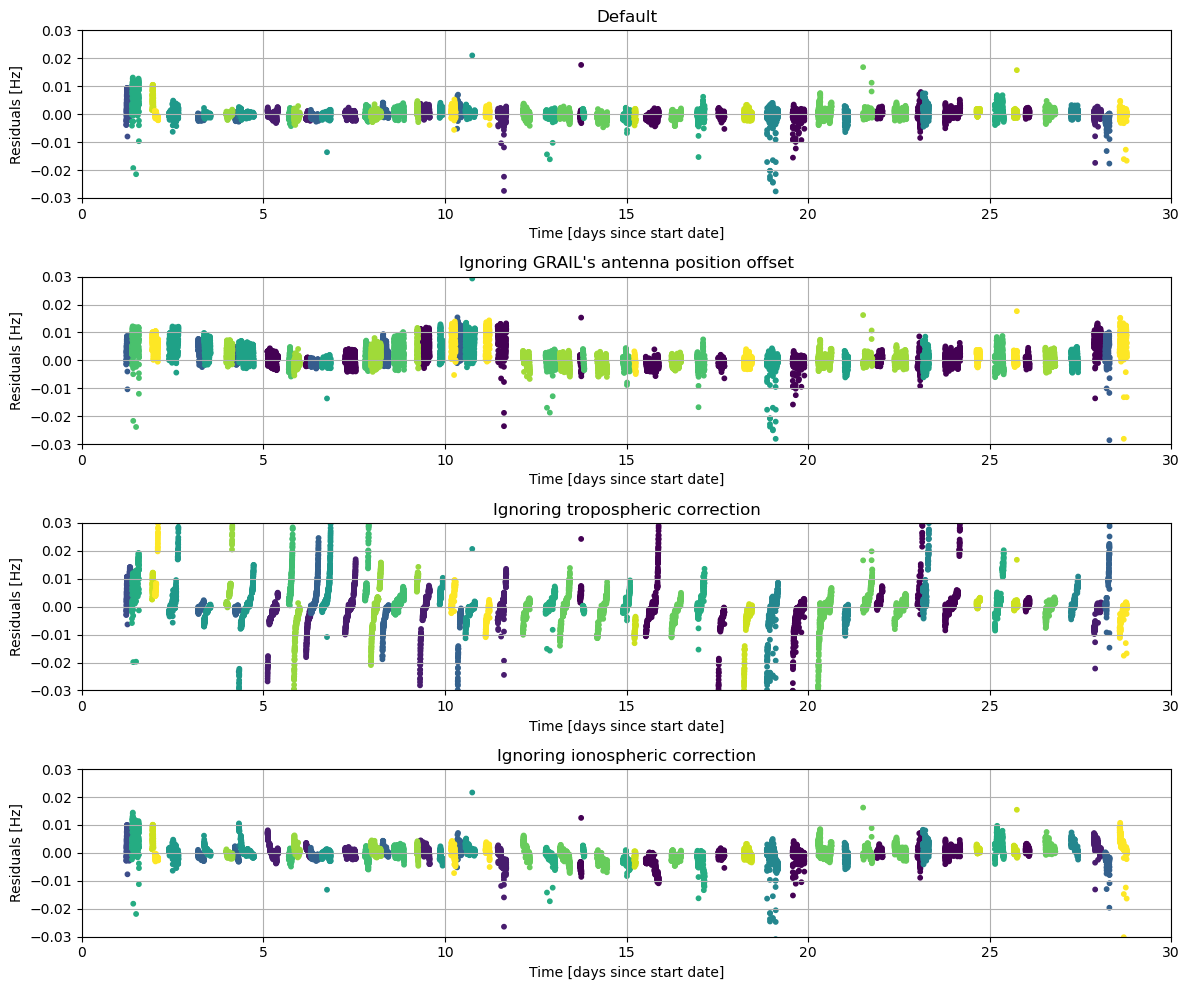

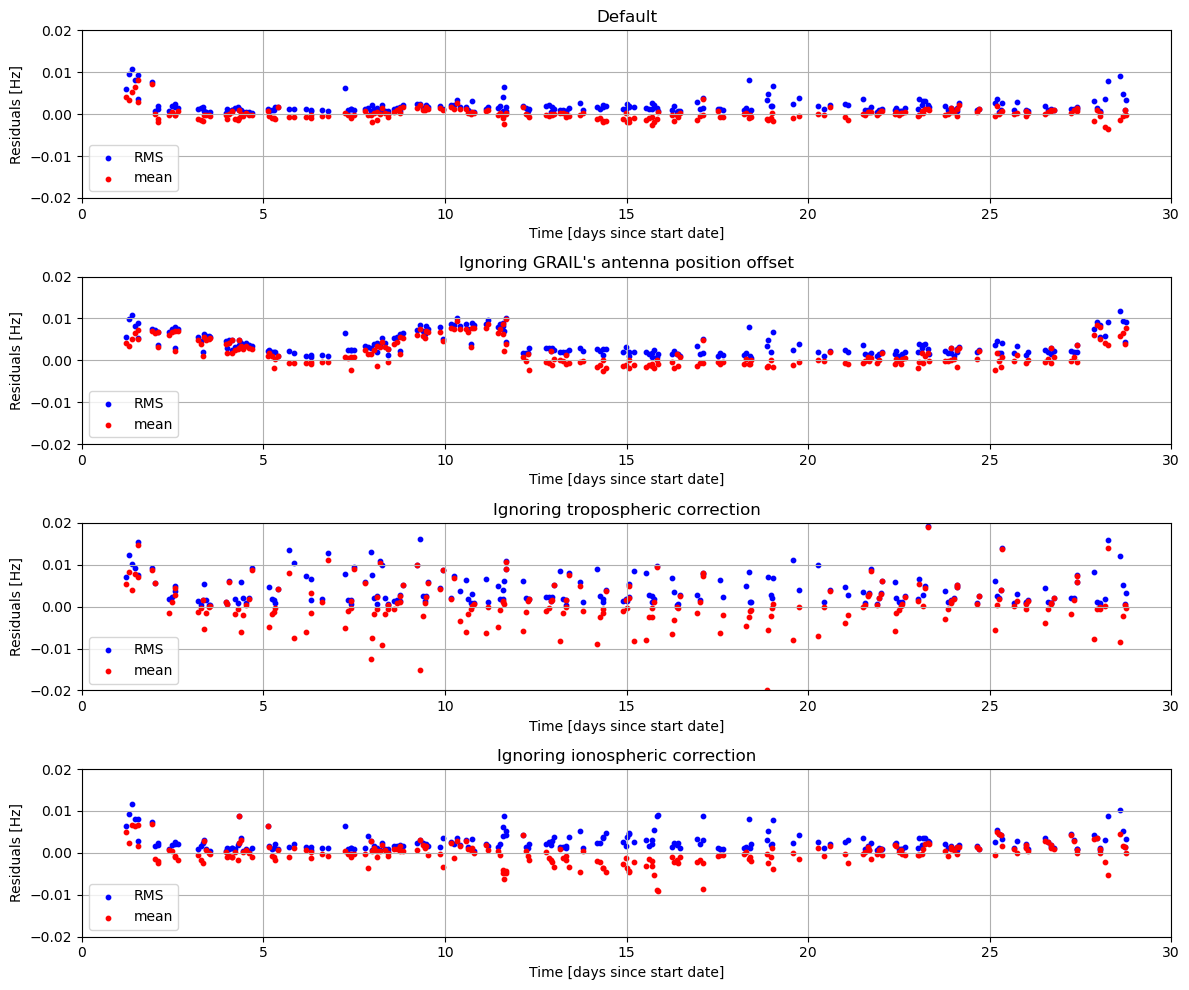

In [7]:
if __name__ == "__main__":
    print("Start")
    inputs = []

    output_folder = "grail_residuals_output/"
    if not os.path.isdir(output_folder):
        os.mkdir(output_folder)

    # Specify the number of different setups to be analysed in parallel in this example
    nb_setups = 4

    # Define start and end dates of the time interval for the residuals analysis
    start_date = datetime(2012, 4, 1)
    end_date = datetime(2012, 4, 30)

    # Retrieve the names of all the relevant kernels and data files necessary to cover the time interval of interest
    (
        clock_file,
        grail_orientation_files,
        tro_files,
        ion_files,
        manoeuvres_file,
        antenna_files,
        odf_files,
        trajectory_files,
        grail_frames_def_file,
        moon_orientation_file,
        lunar_frame_file,
    ) = get_grail_files("grail_kernels/", start_date, end_date)

    # Define number of parallel runs
    nb_parallel_runs = nb_setups
    # Each parallel run covers the full time interval defined by the above start and end dates, but with different settings for the Doppler model.
    # Specifically, the four different setups are the following (setups 1, 2, and 3 being simplified versions of the complete setup 0):
    # setup 0: default
    # setup 1: ignoring GRAIL's antenna position offset (i.e. antenna = center of mass)
    # setup 2: ignoring tropospheric correction
    # setup 3: ignoring ionospheric correction

    # For each setup to be run in parallel
    for i in range(nb_parallel_runs):

        # Construct a list of input arguments containing the arguments needed this specific run.
        # These include the start and end dates, along with the names of all relevant kernels and data files that should be loaded
        inputs.append(
            [
                i,
                start_date,
                end_date,
                odf_files,
                clock_file,
                grail_orientation_files,
                tro_files,
                ion_files,
                antenna_files,
                trajectory_files,
                grail_frames_def_file,
                moon_orientation_file,
                lunar_frame_file,
                output_folder,
            ]
        )

    # Run parallel GRAIL estimations from ODF data
    print("---------------------------------------------")
    print(
        "The output of each parallel estimation is saved in a separate file named grail_residuals_output_x.dat, "
        "with x the index of the run (all output files are saved in " + output_folder
    )
    with mp.get_context("fork").Pool(nb_parallel_runs) as pool:
        pool.map(perform_residuals_analysis, inputs)

    # Load and plot the results of the different residuals analyses.
    fig1, axs1 = plt.subplots(4, 1, figsize=(12, 10))
    fig2, axs2 = plt.subplots(4, 1, figsize=(12, 10))

    setups = [
        "Default",
        "Ignoring GRAIL's antenna position offset",
        "Ignoring tropospheric correction",
        "Ignoring ionospheric correction",
    ]

    for i in range(nb_parallel_runs):

        obs_times = np.loadtxt(output_folder + "observation_times_" + str(i) + ".dat")
        link_ends_ids = np.loadtxt(output_folder + "link_end_ids_" + str(i) + ".dat")
        residuals_wrt_spice = np.loadtxt(
            output_folder + "residuals_wrt_spice_" + str(i) + ".dat"
        )
        time_bounds = np.loadtxt(
            output_folder + "time_bounds_" + str(i) + ".dat", delimiter=","
        )
        residuals_rms = np.loadtxt(output_folder + "residuals_rms_" + str(i) + ".dat")
        residuals_mean = np.loadtxt(output_folder + "residuals_mean_" + str(i) + ".dat")

        start_date_float = time_representation.DateTime.from_python_datetime(start_date).to_epoch()

        # Plot full residuals wrt reference spice trajectory
        axs1[i].scatter(
            (obs_times - start_date_float) / 86400,
            residuals_wrt_spice,
            c=link_ends_ids,
            s=10,
        )
        axs1[i].grid()
        axs1[i].set_ylim([-0.03, 0.03])
        axs1[i].set_xlim([0, 30])
        axs1[i].set_xlabel("Time [days since start date]")
        axs1[i].set_ylabel("Residuals [Hz]")
        axs1[i].set_title(setups[i])

        # Plot RMS and mean residuals (per observation set) wrt reference spice trajectory
        axs2[i].scatter(
            (time_bounds[:, 0] - start_date_float) / 86400,
            residuals_rms,
            s=10,
            color="b",
            label="RMS",
        )
        axs2[i].scatter(
            (time_bounds[:, 0] - start_date_float) / 86400,
            residuals_mean,
            s=10,
            color="r",
            label="mean",
        )
        axs2[i].grid()
        axs2[i].set_ylim([-0.02, 0.02])
        axs2[i].set_xlim([0, 30])
        axs2[i].set_xlabel("Time [days since start date]")
        axs2[i].set_ylabel("Residuals [Hz]")
        axs2[i].set_title(setups[i])
        axs2[i].legend()

    fig1.tight_layout()
    fig2.tight_layout()
    plt.show()